In [1]:
!pip install -q tensorflow keras numpy matplotlib

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Dropout, Concatenate, Conv2DTranspose, Activation
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os
import glob

# **Prepairing Dataset**

Dataset path: /root/.keras/datasets/facades
Contents: [PosixPath('/root/.keras/datasets/facades/test'), PosixPath('/root/.keras/datasets/facades/train'), PosixPath('/root/.keras/datasets/facades/val')]
Found 400 training images


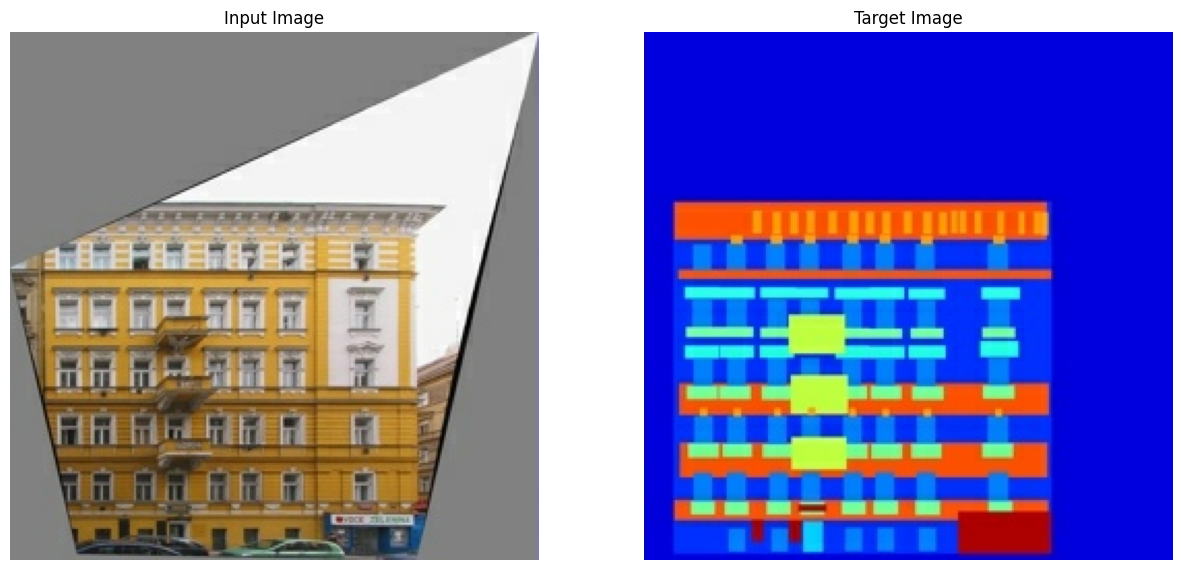

In [3]:
dataset_name = "facades"  
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True
)

path_to_zip = pathlib.Path(path_to_zip)
dataset_path = path_to_zip.parent / dataset_name

print(f"Dataset path: {dataset_path}")
print(f"Contents: {list(dataset_path.iterdir())}")

# Function to load images and split them into input and target pairs
def load(image_file):
    # Load the image file
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    w = tf.shape(image)[1]
    w = w // 2
    
    input_image = image[:, :w, :]
    target_image = image[:, w:, :]
    
    input_image = (input_image * 2.0) - 1.0
    target_image = (target_image * 2.0) - 1.0
    
    return input_image, target_image


# Helper function to display images
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'Target Image', 'Predicted Image']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5) 
        plt.axis('off')
    plt.show()

def load_image_train(image_file):
    input_image, target_image = load(image_file)
    return input_image, target_image

train_images = glob.glob(os.path.join(dataset_path, 'train/*.jpg'))
print(f"Found {len(train_images)} training images")

# Create the dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(1)

# Example of loading and displaying a pair of images
for input_image, target_image in train_dataset.take(1):
    display([input_image[0], target_image[0]])
def load(image_file):
    # Load the image file
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    
    # Cast image to float32 for normalization
    image = tf.cast(image, tf.float32)
    
    # Split the image down the middle into input and target images
    w = tf.shape(image)[1]
    w = w // 2
    
    input_image = image[:, :w, :]
    target_image = image[:, w:, :]
    
    # Normalize images to [-1, 1]
    input_image = (input_image / 127.5) - 1
    target_image = (target_image / 127.5) - 1
    
    return input_image, target_image


In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = 8
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Augment the training images with random flips and resizing
def load_image_train(image_file):
    input_image, target_image = load(image_file)
    
    # Apply some augmentations (random flip, etc.)
    input_image = tf.image.resize(input_image, [IMG_HEIGHT, IMG_WIDTH])
    target_image = tf.image.resize(target_image, [IMG_HEIGHT, IMG_WIDTH])
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        target_image = tf.image.flip_left_right(target_image)
    
    return input_image, target_image

# Apply same resizing to test dataset without augmentations
def load_image_test(image_file):
    input_image, target_image = load(image_file)
    input_image = tf.image.resize(input_image, [IMG_HEIGHT, IMG_WIDTH])
    target_image = tf.image.resize(target_image, [IMG_HEIGHT, IMG_WIDTH])
    return input_image, target_image

# Load the dataset with transformations
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)



# **GENERATOR**

In [5]:
def build_generator(input_shape):
    def conv_block(x, filters, kernel_size=4, strides=2, padding='same', use_dropout=False):
        x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
        x = LeakyReLU(alpha=0.2)(x)
        if use_dropout:
            x = Dropout(0.5)(x)
        return x

    def deconv_block(x, skip_input, filters, kernel_size=4, strides=2, padding='same', use_dropout=False):
        x = Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)(x)
        x = Activation('relu')(x)
        if use_dropout:
            x = Dropout(0.5)(x)
        x = Concatenate()([x, skip_input])
        return x

    inputs = Input(input_shape)

    # Encoder
    d1 = conv_block(inputs, 64, use_dropout=False)
    d2 = conv_block(d1, 128, use_dropout=False)
    d3 = conv_block(d2, 256, use_dropout=False)
    d4 = conv_block(d3, 512, use_dropout=False)
    d5 = conv_block(d4, 512, use_dropout=False)
    d6 = conv_block(d5, 512, use_dropout=False)
    d7 = conv_block(d6, 512, use_dropout=False)

    # Bottleneck
    b = conv_block(d7, 512, use_dropout=False)

    # Decoder
    u1 = deconv_block(b, d7, 512, use_dropout=True)
    u2 = deconv_block(u1, d6, 512, use_dropout=True)
    u3 = deconv_block(u2, d5, 512, use_dropout=True)
    u4 = deconv_block(u3, d4, 512, use_dropout=False)
    u5 = deconv_block(u4, d3, 256, use_dropout=False)
    u6 = deconv_block(u5, d2, 128, use_dropout=False)
    u7 = deconv_block(u6, d1, 64, use_dropout=False)

    outputs = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')(u7)

    return Model(inputs, outputs)


# **Discriminator**

In [6]:
def build_discriminator(input_shape):
    def conv_block(x, filters, kernel_size=4, strides=2, padding='same'):
        x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x

    input_img = Input(input_shape)
    target_img = Input(input_shape)
    combined_imgs = Concatenate()([input_img, target_img])

    d1 = conv_block(combined_imgs, 64)
    d2 = conv_block(d1, 128)
    d3 = conv_block(d2, 256)
    d4 = conv_block(d3, 512)

    outputs = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model([input_img, target_img], outputs)

# **Building**

In [7]:
#Compiling
def compile_pix2pix(generator, discriminator, input_shape):
    discriminator.compile(
        loss='binary_crossentropy', 
        optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5), 
        metrics=['accuracy']
    )
    input_img = tf.keras.layers.Input(shape=input_shape)
    target_img = tf.keras.layers.Input(shape=input_shape)
    generated_img = generator(input_img)
    discriminator.trainable = False
    validity = discriminator([input_img, generated_img])
    combined_model = tf.keras.models.Model(inputs=[input_img, target_img], outputs=[validity, generated_img])
    combined_model.compile(
        loss=['binary_crossentropy', 'mae'],
        loss_weights=[1, 100],
        optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    )
    
    return combined_model


#Training
def train(generator, discriminator, combined_model, dataset, epochs, batch_size):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        for batch_i, (imgs_A, imgs_B) in enumerate(dataset):
            # Ensure correct shapes
            imgs_A = tf.ensure_shape(imgs_A, (batch_size, 256, 256, 3))
            imgs_B = tf.ensure_shape(imgs_B, (batch_size, 256, 256, 3))

            # Train the discriminator
            with tf.GradientTape() as tape:
                fake_B = generator(imgs_A, training=True)

                valid = tf.ones((batch_size,) + discriminator.output_shape[1:], dtype=tf.float32)
                fake = tf.zeros((batch_size,) + discriminator.output_shape[1:], dtype=tf.float32)

                d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = discriminator.train_on_batch([imgs_A, fake_B], fake)

                d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])

            # Train the generator
            with tf.GradientTape() as tape:
                fake_B = generator(imgs_A, training=True)
                valid = tf.ones((batch_size,) + discriminator.output_shape[1:], dtype=tf.float32)

                g_loss = combined_model.train_on_batch([imgs_A, imgs_B], [valid, imgs_B])
                g_loss = g_loss[0]

            print(f"Batch: {batch_i+1}/{len(dataset)//batch_size}, D Loss: {d_loss}, G Loss: {g_loss}")

        print(f"End of Epoch {epoch + 1}/{epochs}")


#Visualization
def plot_results(generator, test_input):
    # Ensure input shape includes batch dimension
    if len(test_input.shape) == 3:
        test_input = tf.expand_dims(test_input, axis=0)
        
    prediction = generator(test_input, training=False)

    plt.figure(figsize=(15, 15))
    for i in range(len(prediction)):
        plt.subplot(1, len(prediction), i + 1)
        plt.imshow((prediction[i] * 0.5 + 0.5))
        plt.axis('off')
    plt.show()


# **Main**

In [ ]:
# Assuming your generator and discriminator are already defined
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)  # Adjust depending on your image dimensions

generator = build_generator(input_shape)
discriminator = build_discriminator(input_shape)
# Compile the models
combined_model = compile_pix2pix(generator, discriminator, input_shape)

# Train the models
train(generator, discriminator, combined_model, train_dataset, epochs=10, batch_size=8)

test_input = np.random.rand(1, *input_shape)  # A batch with one random image

# Visualize some results after training
plot_results(generator, test_input)


generated_images = generator.predict(test_input)
plt.imshow(generated_images[0].astype('uint8'))
plt.axis('off')